In [1]:
import os
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
A = loadmat("./Data_P3/A.mat")["A"].astype(np.float64)
b = loadmat("./Data_P3/b.mat")["b"].astype(np.float64)
X0 = loadmat("./Data_P3/x_0.mat")["x_0"].astype(np.float64)
X1 = loadmat("./Data_P3/x_1.mat")["x_1"].astype(np.float64)

In [3]:
A.shape

(30, 100)

In [4]:
#内置的一维精确搜索算法为牛顿法
class Func():
    def __init__(self, A, b):
        self.delta = 1e-11
        self.epsilon = 1e-11
        self.A = A
        self.n = A.shape[1]
        self.m = A.shape[0]
        self.b = b
        
    def value(self, X):
        return np.sum(X*np.log(X))
    
    def grad(self, X):
        return np.log(X)+1
        
    def hessian(self, X):
        return np.eye(self.n)/X
    
    def diff_t(self, X, D, t):
        return np.dot(self.grad(X+t*D).T, D)
    
    def diff_2_t(self, X, D, t):
        return np.dot(D.T, np.dot(self.hessian(X+t*D), D))
    
    def Newton_1D_Method(self, X0, D, delta):#一维精确搜索——牛顿法
        t_tmp=0
        while(abs(self.diff_t(X0,D,t_tmp))>delta or delta_t>1e-3):
            t_tmp = new_t_tmp
            #if(np.sum((X0+t_tmp+D<=0))>0):
            #    break
            new_t_tmp=t_tmp-self.diff_t(X0,D,t_tmp)/self.diff_2_t(X0,D,t_tmp)
            delta_t = np.abs(new_t_tmp - t_tmp)
            t_tmp = new_t_tmp
        return X0+t_tmp*D
    
    def Backtracking(self, X0, D, delta, alpha = 0.4, beta = 0.7):
        t = 1
        idxs = np.where(X0+t*D<0)
        scale = np.abs(X0[idxs])/np.abs((t*D)[idxs])
        if(scale.shape[0]>0):
            t = t*np.min(scale)*0.9
        while(self.value(X0+t*D) > self.value(X0) + alpha*t*np.dot(self.grad(X0).T,D)):
            t = beta*t
        '''   
        plt.figure()
        ts = np.arange(1,100000, 1)
        vs = []
        for t_ in ts:
            vs.append(self.value(X0+D*t_))
        plt.plot(ts,vs)
        plt.show()
        return 
        '''
        learning_rate = 0.001
        num_iter = 0
        max_iter = 1000
        while(abs(self.diff_t(X0,D,t))>delta):
            delta_t = -self.diff_t(X0,D,t)/self.diff_2_t(X0,D,t)
            #delta_t = -learning_rate*self.diff_t(X0,D,t)
            idxs = np.where(X0+(t+delta_t)*D<0)
            scale = np.abs((X0+t*D)[idxs])/np.abs((delta_t*D)[idxs])
            if(scale.shape[0]>0):
                delta_t = delta_t*np.min(scale)*0.9
            t = t + delta_t
            num_iter+=1
            #if(num_iter >= max_iter):
            #    break
        return X0+t*D, np.sqrt(np.sum((t*D)**2))
    
    def NewtonMethod_fisible(self, X0, epsilon):
        if(np.prod(np.dot(self.A, X0) - self.b)!=0):
            print("It's not a fisible point!")
            return None
        else:
            tmp_x = X0
            values = [self.value(tmp_x)]
            t_ks = []
            hessian = self.hessian(tmp_x)
            hessian_inv = np.linalg.inv(hessian)
            a = np.dot(hessian_inv, self.grad(tmp_x))
            b = np.linalg.inv(np.dot(self.A, np.dot(hessian, self.A.T)))
            w = -np.dot(np.dot(b, self.A), a)
            d = -a-np.dot(hessian_inv, np.dot(A.T, w))
            d = d/np.linalg.norm(d)
            lambda_square = -np.dot(self.grad(tmp_x).T, d)
            print("error: ", (lambda_square[0,0]/2))
            while(lambda_square/2 > epsilon):
                tmp_x, t_k = self.Backtracking(tmp_x, d, self.delta)
                #print(tmp_x)
                hessian = self.hessian(tmp_x)
                hessian_inv = np.linalg.inv(hessian)
                a = np.dot(hessian_inv, self.grad(tmp_x))
                b = np.linalg.inv(np.dot(self.A, np.dot(hessian, self.A.T)))
                w = -np.dot(np.dot(b, self.A), a)
                d = -a-np.dot(hessian_inv, np.dot(A.T, w))
                d = d/np.linalg.norm(d)
                lambda_square = -np.dot(self.grad(tmp_x).T, d)
                values.append(self.value(tmp_x))
                t_ks.append(t_k)
                print("error: ", (lambda_square[0,0]/2))
            
            return self.value(tmp_x), np.array(values), np.array(t_ks).reshape(-1)
    
    def GradMethod(self, X0, epsilon, step = 0.01):
        tmp_x = X0
        grad = self.grad(tmp_x)
        while(np.dot(grad.T,grad)>epsilon):
            print(self.value(tmp_x))
            tmp_x = tmp_x - step*grad
            
        return tmp_x

In [5]:
func1 = Func(A,b)
opt_value1, values1, tks1 = func1.NewtonMethod_fisible(X0, epsilon=1e-10)

error:  3.0196504818850487
error:  1.9883667920716177
error:  0.9475502885503928
error:  0.32593253225501395
error:  0.044115716972440315
error:  0.003122745034422829
error:  0.00021791502943880407
error:  1.5188176491034475e-05
error:  1.058518727447562e-06
error:  7.377154614187553e-08
error:  5.141372680684379e-09
error:  3.583184793008879e-10
error:  2.497235864500389e-11


/tmp/ipykernel_253/2081299776.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(values1-opt_value1), "-o", label="optimal value = %f"%(opt_value1))


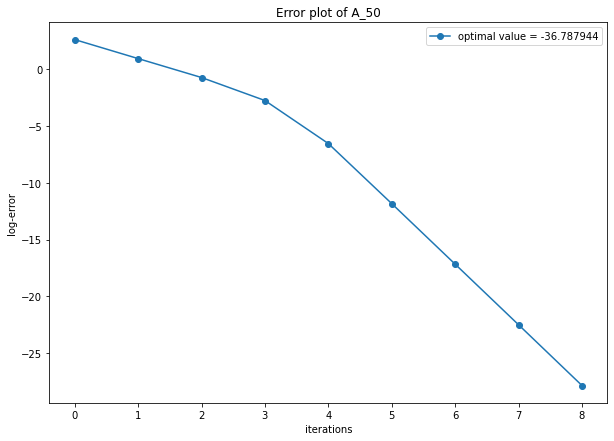

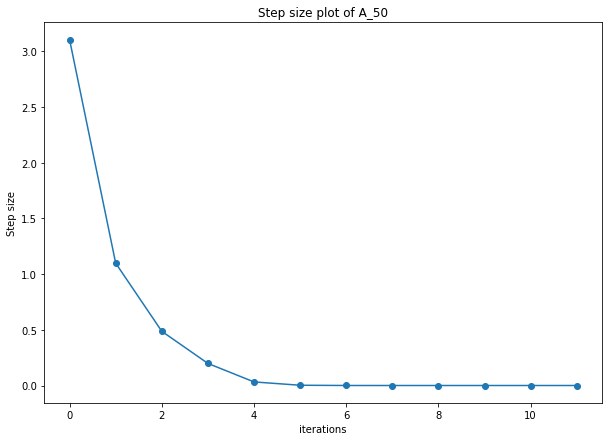

In [6]:
plt.figure(figsize=(10,7))
plt.plot(np.log(values1-opt_value1), "-o", label="optimal value = %f"%(opt_value1))
plt.xlabel("iterations")
plt.ylabel("log-error")
plt.title("Error plot of A_50")
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(tks1, "-o")
plt.xlabel("iterations")
plt.ylabel("Step size")
plt.title("Step size plot of A_50")
plt.show()

In [7]:
opt_value2, values2, tks2 = func1.NewtonMethod_fisible(X1, epsilon=1e-10)

It's not a fisible point!


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.log(values2-opt_value2), "-o", label="optimal value = %f"%(opt_value2))
plt.xlabel("iterations")
plt.ylabel("log-error")
plt.title("Error plot of A_100")
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.plot(tks2, "-o")
plt.xlabel("iterations")
plt.ylabel("Step size")
plt.title("Step size plot of A_100")
plt.show()